In [1]:
library(liana)
library(Seurat)
library(tibble)
library(purrr)
library(gprofiler2)
library(tidyverse)
library(SummarizedExperiment)

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tidyr     1.3.0
✔ lubridate 1.9.2     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [24]:
options(repr.plot.width = 18, repr.plot.height = 17, repr.plot.pointsize = 24)

In [2]:
op_resource <- select_resource("OmniPath")[[1]]

In [3]:
genes <- union(op_resource$source_genesymbol, op_resource$target_genesymbol)

In [4]:
genes_convert <- gorth(query = genes, source_organism = "hsapiens", target_organism = "sscrofa")

In [5]:
genes_convert <- genes_convert[!duplicated(genes_convert$input_number),]

In [6]:
op_resource <- op_resource %>%
        left_join(genes_convert, by=c("target_genesymbol"="input")) %>%
        mutate(target_genesymbol = ortholog_name, .keep = "unused") %>%
        left_join(genes_convert, by=c("source_genesymbol"="input")) %>%
        mutate(source_genesymbol = ortholog_name, .keep = "unused") %>%
        filter(!is.na(target_genesymbol) | !is.na(source_genesymbol)) %>%
        filter(!is.na(target_genesymbol)) %>%
        filter(!is.na(source_genesymbol))

In [7]:
embryo <- readRDS("/home/adufour/work/rds_storage/omics/rna_multiome_matrix.rds")
cellmetadata <- readRDS("/home/adufour/work/rds_storage/omics/rna_multiome_matrix_cell_metadata.rds")

In [8]:
embryo.data <- as.matrix(assays(embryo)$GeneExpressionMatrix)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 8.1 GiB”


In [9]:
rownames(embryo.data) <- embryo@elementMetadata$name

In [10]:
embryo_obj <- CreateSeuratObject(counts = embryo.data)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [11]:
embryo_obj@meta.data <- as.data.frame(embryo@colData)

In [12]:
Idents(embryo_obj) <- "Clusters"

In [13]:
liana_test <- liana_wrap(embryo_obj,
                         method = c("sca", "natmi", "logfc", "connectome", "call_italk", "call_connectome"),
                         resource = "custom",
                         external_resource = op_resource)

Expression from the `RNA` assay will be used

Running LIANA with `colLabels`/`Idents` as labels (matching column in metadata not found).

Warning message in exec(output, ...):
“2244 genes and/or 0 cells were removed as they had no counts!”
Warning message:
“`invoke()` is deprecated as of rlang 0.4.0.
Please use `exec()` or `inject()` instead.
This warning is displayed once every 8 hours.”
LIANA: LR summary stats calculated!

Now Running: Sca

Now Running: Natmi

Now Running: Logfc

Now Running: Connectome

Now Running: Call_italk

Calculating cluster C2

Calculating cluster C4

Calculating cluster C3

Calculating cluster C6

Calculating cluster C5

Calculating cluster C1

Warning message:
“remplacement de l'importation précédente ‘Biobase::combine’ par ‘dplyr::combine’ lors du chargement de ‘iTALK’”
Warning message:
“remplacement de l'importation précédente ‘dplyr::as_data_frame’ par ‘igraph::as_data_frame’ lors du chargement de ‘iTALK’”
Warning message:
“remplacement de l'importation 

  |                                                                      |   0%

Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable courte et ont été éliminés”
Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable courte et ont été éliminés”
Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable courte et ont été éliminés”
Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable courte et ont été éliminés”
Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable courte et ont été éliminés”
Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable co

  |============                                                          |  17%

Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable courte et ont été éliminés”
Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable courte et ont été éliminés”
Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable courte et ont été éliminés”
Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable courte et ont été éliminés”
Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable courte et ont été éliminés”
Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable co

  |=======================                                               |  33%

Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable courte et ont été éliminés”
Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable courte et ont été éliminés”
Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable courte et ont été éliminés”
Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable courte et ont été éliminés”
Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable courte et ont été éliminés”
Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable co

  |===================================                                   |  50%

Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable courte et ont été éliminés”
Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable courte et ont été éliminés”
Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable courte et ont été éliminés”
Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable courte et ont été éliminés”
Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable courte et ont été éliminés”
Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable co

  |===============================================                       |  67%

Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable courte et ont été éliminés”
Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable courte et ont été éliminés”
Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable courte et ont été éliminés”
Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable courte et ont été éliminés”
Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable courte et ont été éliminés”
Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable co

  |==========================================================            |  83%

Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable courte et ont été éliminés”
Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable courte et ont été éliminés”
Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable courte et ont été éliminés”
Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable courte et ont été éliminés”
Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable courte et ont été éliminés”
Warning message in data.frame(source = sources[i], target = targets[j], ligand = ligands, :
“les noms de lignes sont trouvés dans une variable co

  |======================================================================| 100%


Mapping ligand p-values


Mapping receptor p-values


Connectome generation complete


Pre-filter edges:  146880


Post-filter edges:  142956


Connectome filtration completed



In [14]:
liana_test %>% glimpse

List of 6
 $ sca            : tibble [24,513 × 12] (S3: tbl_df/tbl/data.frame)
  ..$ source          : chr [1:24513] "C2" "C2" "C2" "C2" ...
  ..$ target          : chr [1:24513] "C2" "C2" "C2" "C2" ...
  ..$ ligand.complex  : chr [1:24513] "PRNP" "BMPR1B" "CHL1" "PTPRT" ...
  ..$ ligand          : chr [1:24513] "PRNP" "BMPR1B" "CHL1" "PTPRT" ...
  ..$ receptor.complex: chr [1:24513] "NCAM1" "BMPR2" "TMEM132A" "CDH1" ...
  ..$ receptor        : chr [1:24513] "NCAM1" "BMPR2" "TMEM132A" "CDH1" ...
  ..$ receptor.prop   : num [1:24513] 0.253 0.909 0.461 0.97 0.23 ...
  ..$ ligand.prop     : num [1:24513] 0.176 0.531 0.228 0.215 0.128 ...
  ..$ ligand.expr     : num [1:24513] 0.136 0.991 0.282 0.244 0.096 ...
  ..$ receptor.expr   : num [1:24513] 0.343 4.024 0.465 8.066 0.196 ...
  ..$ global_mean     : num [1:24513] 0.312 0.312 0.312 0.312 0.312 ...
  ..$ LRscore         : num [1:24513] 0.409 0.865 0.537 0.818 0.306 ...
 $ natmi          : tibble [24,513 × 14] (S3: tbl_df/tbl/data.frame)


In [15]:
liana_result <- liana_test %>% liana_aggregate() %>% as.data.frame()

Warning message in exec(output, ...):
“Using internal and external methods should be done with caution!”
Now aggregating sca

Now aggregating natmi

Now aggregating logfc

Now aggregating connectome

Now aggregating call_italk

Now aggregating call_connectome

Aggregating Ranks



In [16]:
liana_result

source,target,ligand,receptor,aggregate_rank,mean_rank,sca.LRscore,sca.rank,natmi.edge_specificity,natmi.rank,logfc.logfc_comb,logfc.rank,connectome.weight_sc,connectome.rank,call_italk.logfc_comb,call_italk.rank,call_connectome.weight_sc,call_connectome.rank
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C1,C5,APOA1,LRP2,1.745434e-17,2973.583,0.9951212,1.0,0.5986766,3.0,-172.9872750,5693.0,3.9987610,2.0,-0.2185,12140.5,3.7873749,2.0
C1,C5,APOC3,LRP2,1.413706e-15,2974.417,0.9828803,9.0,0.7701335,1.0,-173.4438198,5694.0,4.3483003,1.0,-0.2185,12140.5,3.8957553,1.0
C1,C5,APOE,LRP2,7.147617e-14,2978.917,0.9881851,4.0,0.3885820,24.0,-176.8488152,5699.0,3.4333567,3.0,-0.2185,12140.5,3.2312248,3.0
C2,C5,THBS1,LRP2,2.554632e-13,4894.583,0.9746869,33.0,0.5175051,9.0,-552.8554142,17175.0,2.6874169,5.0,-0.2185,12140.5,2.4850281,5.0
C3,C5,HSPG2,LRP2,2.437042e-12,3912.750,0.9709857,58.0,0.3370340,49.0,-411.0613021,11206.0,2.4732667,13.0,-0.2185,12140.5,2.2718046,10.0
C1,C1,APOE,SCARB1,6.717861e-12,2176.083,0.9705628,61.0,0.2031384,407.0,228.5398561,50.0,1.5878618,121.0,-0.2185,12140.5,1.5863428,277.0
C2,C4,CDH1,IGF1R,1.085288e-11,4419.500,0.9676311,77.5,0.1979943,448.5,-507.3531891,13315.5,1.2132903,197.5,-0.2185,12140.5,1.2131722,337.5
C1,C5,APOA2,LRP2,1.408706e-11,3003.917,0.9651987,105.0,0.5501591,7.0,-184.8268445,5763.0,3.1456190,4.0,-0.2185,12140.5,2.9166022,4.0
C3,C5,LDLR,LRP2,3.634947e-11,3927.083,0.9644057,114.0,0.3255853,60.0,-412.7925860,11215.0,2.4322017,17.0,-0.2185,12140.5,2.2298663,16.0


In [17]:
saveRDS(liana_result, file = "/home/adufour/work/rds_storage/LR/liana/liana_multiomics.rds")

In [18]:
library(tidyverse)
library(liana)
library(nichenetr)
library(Seurat)
library(ggrepel)
library(cowplot)


Attachement du package : ‘cowplot’


L'objet suivant est masqué depuis ‘package:lubridate’:

    stamp




In [21]:
# filter results to cell types of interest
C4_C2_results <- liana_result %>%
  subset(source == "C4" & target == "C2")

In [22]:
# filter results to top N interactions
n <- 50
top_n_C4_C2 <- C4_C2_results %>%
  arrange(aggregate_rank) %>%
  slice_head(n = n) %>%
  mutate(id = fct_inorder(paste0(ligand, " -> ", receptor)))

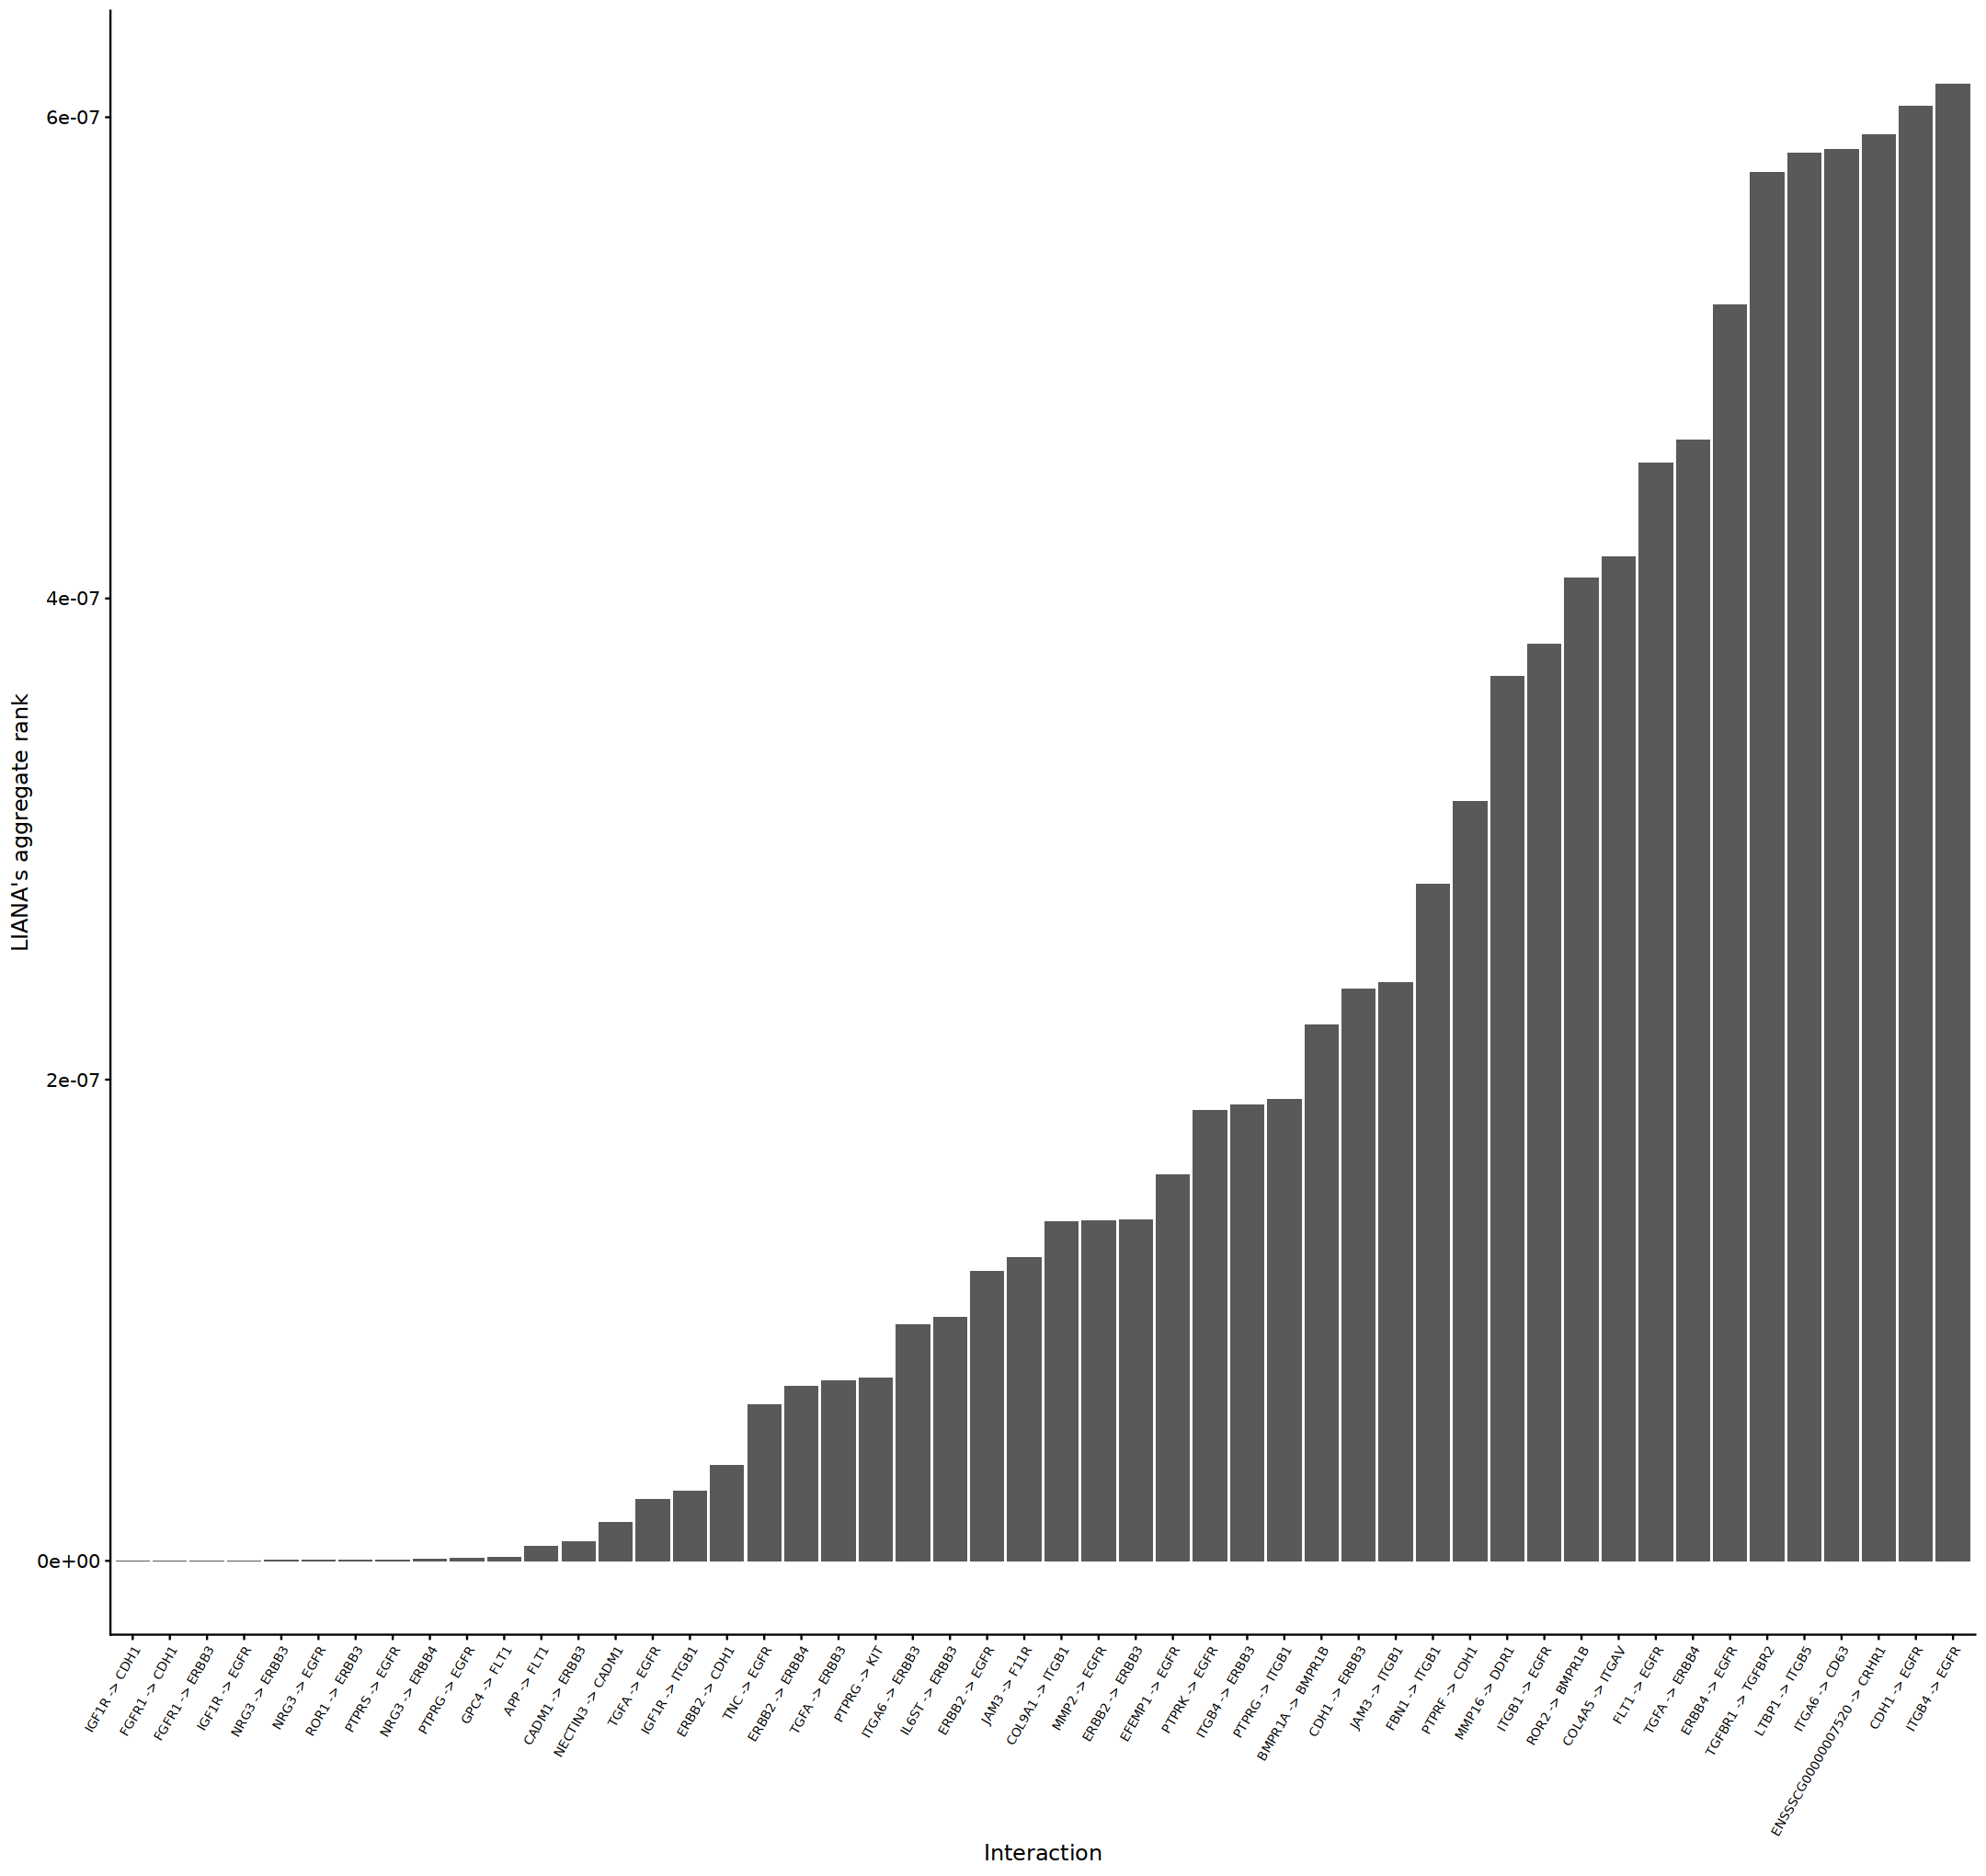

In [25]:
# visualize median rank
top_n_C4_C2 %>%
  ggplot(aes(y = aggregate_rank, x = id)) +
  geom_bar(stat = "identity") +
  xlab("Interaction") + ylab("LIANA's aggregate rank") +
  theme_cowplot() +
  theme(axis.text.x = element_text(size = 8, angle = 60, hjust = 1, vjust = 1))

In [27]:
ligand_target_matrix = readRDS(url("https://zenodo.org/record/7074291/files/ligand_target_matrix_nsga2r_final.rds"))

In [41]:
# get ligands and filter to those included in NicheNet's ligand-target matrix
ligands <- c(unique(top_n_C4_C2$ligand), "GNAS")
ligands <- ligands[ligands %in% colnames(ligand_target_matrix)]
ligands

[1] "NRG3"    "APP"     "CADM1"   "NECTIN3" "TGFA"    "TNC"     "JAM3"   
 [8] "COL9A1"  "MMP2"    "EFEMP1"  "PTPRK"   "CDH1"    "FBN1"    "MMP16"  
[15] "ITGB1"   "COL4A5"  "LTBP1"   "GNAS"

In [40]:
"GNAS" %in% colnames(ligand_target_matrix)

[1] TRUE

In [34]:
grep("IGF", colnames(ligand_target_matrix), value = TRUE)

[1] "IGF1"    "IGF2"    "IGFBP3"  "IGFBP4"  "IGFBP7"  "IGFBPL1" "IGFL1"  
[8] "IGFL2"   "IGFL3"

In [42]:
expression <- embryo.data
sample_info <- embryo_obj@meta.data
colnames(sample_info) <- make.names(colnames(sample_info))

In [48]:
sample_info <- sample_info %>%
  subset(Clusters %in% c("C2", "C4"))

In [50]:
sample_info$cell <- rownames(sample_info)

In [53]:
expression <- expression[,sample_info$cell ]

In [54]:
expression <- t(expression)

In [57]:
background_genes <- expression[sample_info$cell[sample_info$Clusters == "C4"], ] %>%
  apply(2,function(x){10*(2**x - 1)}) %>%
  apply(2,function(x){log2(mean(x) + 1)}) %>%
  .[. >= 4] %>%
  names()

In [55]:
head(expression)

,ENSSSCG00000048769,ENSSSCG00000037372,PSMB1,ENSSSCG00000049216,FAM120B,DLL1,ENSSSCG00000053918,ERMARD,DYNLT2,PHF10,⋯,ENSSSCG00000057265,SRY,ENSSSCG00000059393,ENSSSCG00000035670,ENSSSCG00000061633,ENSSSCG00000034141,ENSSSCG00000055051,ENSSSCG00000056875,ENSSSCG00000062133,ENSSSCG00000060796
lw9#GCTCTGTTCCATTACT-1,0.0000000,0.0000000,0.4069286,0,0.2712858,0.0000000,0,1.0851430,0.0000000,0.5425715,⋯,0,0,0,0,0,0,0,0,0,0
lw9#TGGCCTTTCCTCCATA-1,0.0000000,0.0000000,0.7703863,0,0.7703863,0.0000000,0,0.5135909,0.2567954,0.3851932,⋯,0,0,0,0,0,0,0,0,0,0
lw9#TATGGCCCAAGCCAGA-1,0.0000000,0.1773962,1.0643771,0,0.1773962,0.0000000,0,0.5321885,0.0000000,0.5321885,⋯,0,0,0,0,0,0,0,0,0,0
lw9#TGTTAGCAGGTGCGGA-1,0.0000000,0.0000000,0.0000000,0,0.4493776,0.4493776,0,0.0000000,0.0000000,0.0000000,⋯,0,0,0,0,0,0,0,0,0,0
lw9#CTGTTAAAGGCAGGTG-1,0.1526671,0.1526671,1.0686697,0,0.6106684,0.0000000,0,0.3053342,0.0000000,0.3053342,⋯,0,0,0,0,0,0,0,0,0,0
lw9#CATTCATTCAGCATTA-1,0.1333778,0.0000000,0.9336445,0,0.4001334,0.0000000,0,0.0000000,0.1333778,0.2667556,⋯,0,0,0,0,0,0,0,0,0,0


In [58]:
geneset_oi <- read_tsv(url("https://zenodo.org/record/3260758/files/pemt_signature.txt"), col_types = cols(), col_names = "gene") %>%
  pull(gene) %>%
  .[. %in% rownames(ligand_target_matrix)]

In [63]:
DE_table_receiver = FindMarkers(object = embryo_obj, ident.1 = "C2", ident.2 = "C4", min.pct = 0.10) %>% rownames_to_column("gene")

geneset_oi = DE_table_receiver %>% filter(p_val_adj <= 0.05 & abs(avg_log2FC) >= 0.25) %>% pull(gene)
geneset_oi = geneset_oi %>% .[. %in% rownames(ligand_target_matrix)]

In [64]:
geneset_oi

[1] "FNDC1"      "EZR"        "ARID1B"     "PTPRK"      "PKIB"      
   [6] "ADGRB3"     "GRIK2"      "CRYBG1"     "CD24"       "FOXO3"     
  [11] "TRAF3IP2"   "TENT5A"     "PHIP"       "MYO6"       "MYO5B"     
  [16] "TCF4"       "ANXA2"      "MYZAP"      "TCF12"      "SPINT1"    
  [21] "IGF1R"      "GABRB3"     "TJP1"       "DOK6"       "ATP8B1"    
  [26] "LGALS3"     "SYNE2"      "PSIP1"      "FREM1"      "RFX3"      
  [31] "PIP5K1B"    "TJP2"       "ANXA1"      "OSTF1"      "GCNT1"     
  [36] "BSPRY"      "ZNF618"     "PTGES"      "FNBP1"      "CEP170"    
  [41] "ZEB1"       "VIM"        "FAM171A1"   "FRMD4A"     "SFMBT2"    
  [46] "NBEA"       "DCLK1"      "LRCH1"      "ELF1"       "DACH1"     
  [51] "KLF5"       "GPC6"       "MBNL2"      "DOCK9"      "NALF1"     
  [56] "METRNL"     "SEPTIN9"    "LLGL2"      "PITPNC1"    "BPTF"      
  [61] "KRT19"      "EPN3"       "MYO1D"      "CLDN7"      "NTN1"      
  [66] "USP43"      "GAS7"       "ZNF385D"    "THRB"       "OSBPL10"   
  [71] "CDCP1"      "FLNB"       "SYNPR"      "MAGI1"      "LRRN1"     
  [76] "ACP3"       "PCOLCE2"    "TM4SF1"     "WWTR1"      "PLCH1"     
  [81] "NLGN1"      "ITGB5"      "ILDR1"      "LSAMP"      "ALCAM"     
  [86] "VGLL3"      "ROBO1"      "ROBO2"      "TMPRSS2"    "RHOBTB2"   
  [91] "KIF13B"     "SPOCK3"     "TTC28"      "SMTN"       "LIMK2"     
  [96] "KCNK1"      "KCNMA1"     "NRG3"       "MARCHF8"    "PDLIM1"    
 [101] "SORCS1"     "CPXM2"      "ADAM8"      "CACNB4"     "KIF5C"     
 [106] "LRP1B"      "NXPH2"      "FGFR1"      "COBLL1"     "GALNT3"    
 [111] "CASP10"     "IGFBP2"     "SGPP2"      "ANKRD33B"   "CTNND2"    
 [116] "MYO10"      "FST"        "PLK2"       "OCLN"       "MAP1B"     
 [121] "TNPO1"      "GABRP"      "GM2A"       "AHRR"       "SFRP1"     
 [126] "FERMT1"     "SLC24A3"    "TFAP2C"     "ESYT2"      "DPP6"      
 [131] "MKRN1"      "PTN"        "CTTNBP2"    "TES"        "CREB5"     
 [136] "UPP1"       "IGFBP3"     "POU6F2"     "SIGIRR"     "PHLDA2"    
 [141] "CCND1"      "CST6"       "OVOL1"      "FAM111A"    "CACNA1A"   
 [146] "LRRC8E"     "CRB3"       "PTPRS"      "PLPP2"      "F2RL1"     
 [151] "SSBP2"      "ELL2"       "PAM"        "MCC"        "SEMA6A"    
 [156] "CTNNA1"     "SH3RF2"     "JAKMIP2"    "CSNK1A1"    "BAIAP2L1"  
 [161] "CLDN4"      "PRKCB"      "PPL"        "SLC20A1"    "PROM2"     
 [166] "ST6GAL2"    "ZNF638"     "BCL11A"     "CCDC88A"    "NRXN1"     
 [171] "EPCAM"      "MAP4K3"     "SOS1"       "DPYSL5"     "MBOAT2"    
 [176] "MROH1"      "LRATD2"     "SNTB1"      "GRHL2"      "YWHAZ"     
 [181] "SPAG1"      "LAPTM4B"    "ESRP1"      "MMP16"      "ATP6V0D2"  
 [186] "JPH1"       "PREX2"      "NME7"       "RAB25"      "S100A14"   
 [191] "S100A6"     "S100A10"    "HENMT1"     "ARHGAP8"    "MYH9"      
 [196] "KRT7"       "KRT8"       "KRT18"      "DGKA"       "ERBB3"     
 [201] "GPRC5A"     "ANO6"       "SLC38A1"    "TMCC3"      "EEA1"      
 [206] "CDH1"       "CDH3"       "CDH11"      "ESRP2"      "TOX3"      
 [211] "ZNF423"     "SPINT2"     "CYP2S1"     "PLAUR"      "PPP1R13L"  
 [216] "MYH14"      "TNNT1"      "ISG15"      "ERRFI1"     "SLC2A5"    
 [221] "DHRS3"      "PDPN"       "EFHD2"      "CDA"        "GRHL3"     
 [226] "SFN"        "TINAGL1"    "GJB3"       "GATA6"      "ZNF521"    
 [231] "CDH2"       "DSC2"       "B4GALT6"    "DTNA"       "FHOD3"     
 [236] "ST6GALNAC3" "NEGR1"      "CACHD1"     "ROR1"       "PATJ"      
 [241] "TACSTD2"    "DAB1"       "RNF220"     "DSP"        "TFAP2A"    
 [246] "RNF182"     "GABBR1"     "IER3"       "FAM83B"     "ITPR3"     
 [251] "CYP1A1"     "RGS6"       "CALM1"      "RIN3"       "ARAP2"     
 [256] "RBM47"      "NIPAL1"     "PDGFC"      "SOWAHB"     "SEPTIN11"  
 [261] "FHIP1A"     "SH3D19"     "MAML3"      "CAMK2D"     "UNC5C"     
 [266] "PDLIM5"     "HERC5"      "PPM1K"      "TENM4"      "CTSC"      
 [271] "FOLH1"      "MAML2"      "UPK2"       "ST14"       "ETV1"      
 [276] "DGKB"       "MACC1"      "MAGI2"   

In [59]:
geneset_oi

[1] "SERPINE1"  "TGFBI"     "MMP10"     "LAMC2"     "P4HA2"     "PDPN"     
 [7] "ITGA5"     "LAMA3"     "CDH13"     "TNC"       "MMP2"      "EMP3"     
[13] "INHBA"     "LAMB3"     "VIM"       "SEMA3C"    "ANXA5"     "DHRS7"    
[19] "ITGB1"     "ACTN1"     "ITGB6"     "IGFBP7"    "THBS1"     "PTHLH"    
[25] "TNFRSF6B"  "PDLIM7"    "CAV1"      "DKK3"      "COL17A1"   "LTBP1"    
[31] "COL5A2"    "COL1A1"    "FHL2"      "TIMP3"     "PLAU"      "LGALS1"   
[37] "PSMD2"     "CD63"      "HERPUD1"   "TPM1"      "SLC39A14"  "C1S"      
[43] "MMP1"      "EXT2"      "COL4A2"    "PRSS23"    "SLC7A8"    "SLC31A2"  
[49] "ARPC1B"    "APP"       "MFAP2"     "MPZL1"     "MT2A"      "MAGED2"   
[55] "ITGA6"     "FSTL1"     "TNFRSF12A" "IL32"      "COPB2"     "PTK7"     
[61] "OCIAD2"    "TAX1BP3"   "SEC13"     "SERPINH1"  "TPM4"      "MYH9"     
[67] "ANXA8L1"   "PLOD2"     "GALNT2"    "MAGED1"    "SLC38A5"   "FSTL3"    
[73] "CD99"      "F3"        "PSAP"      "NMRK1"     "FKBP9"     "DSG2"     
[79] "ECM1"      "HTRA1"     "SERINC1"   "CALU"      "TPST1"     "PLOD3"    
[85] "IGFBP3"    "FRMD6"     "CXCL14"    "SERPINE2"  "RABAC1"    "TMED9"    
[91] "NAGK"      "BMP1"      "ESYT1"     "STON2"     "TAGLN"     "GJA1"

In [65]:
nichenet_activities <- predict_ligand_activities(
  geneset = geneset_oi,
  background_expressed_genes = background_genes,
  ligand_target_matrix = ligand_target_matrix, potential_ligands = ligands
)

In [66]:
# prepare data for visualization
vis_liana_nichenet <- top_n_C4_C2 %>%
  inner_join(nichenet_activities, by = c("ligand" = "test_ligand")) %>%
  arrange(pearson) %>%
  mutate(ligand = fct_inorder(ligand))

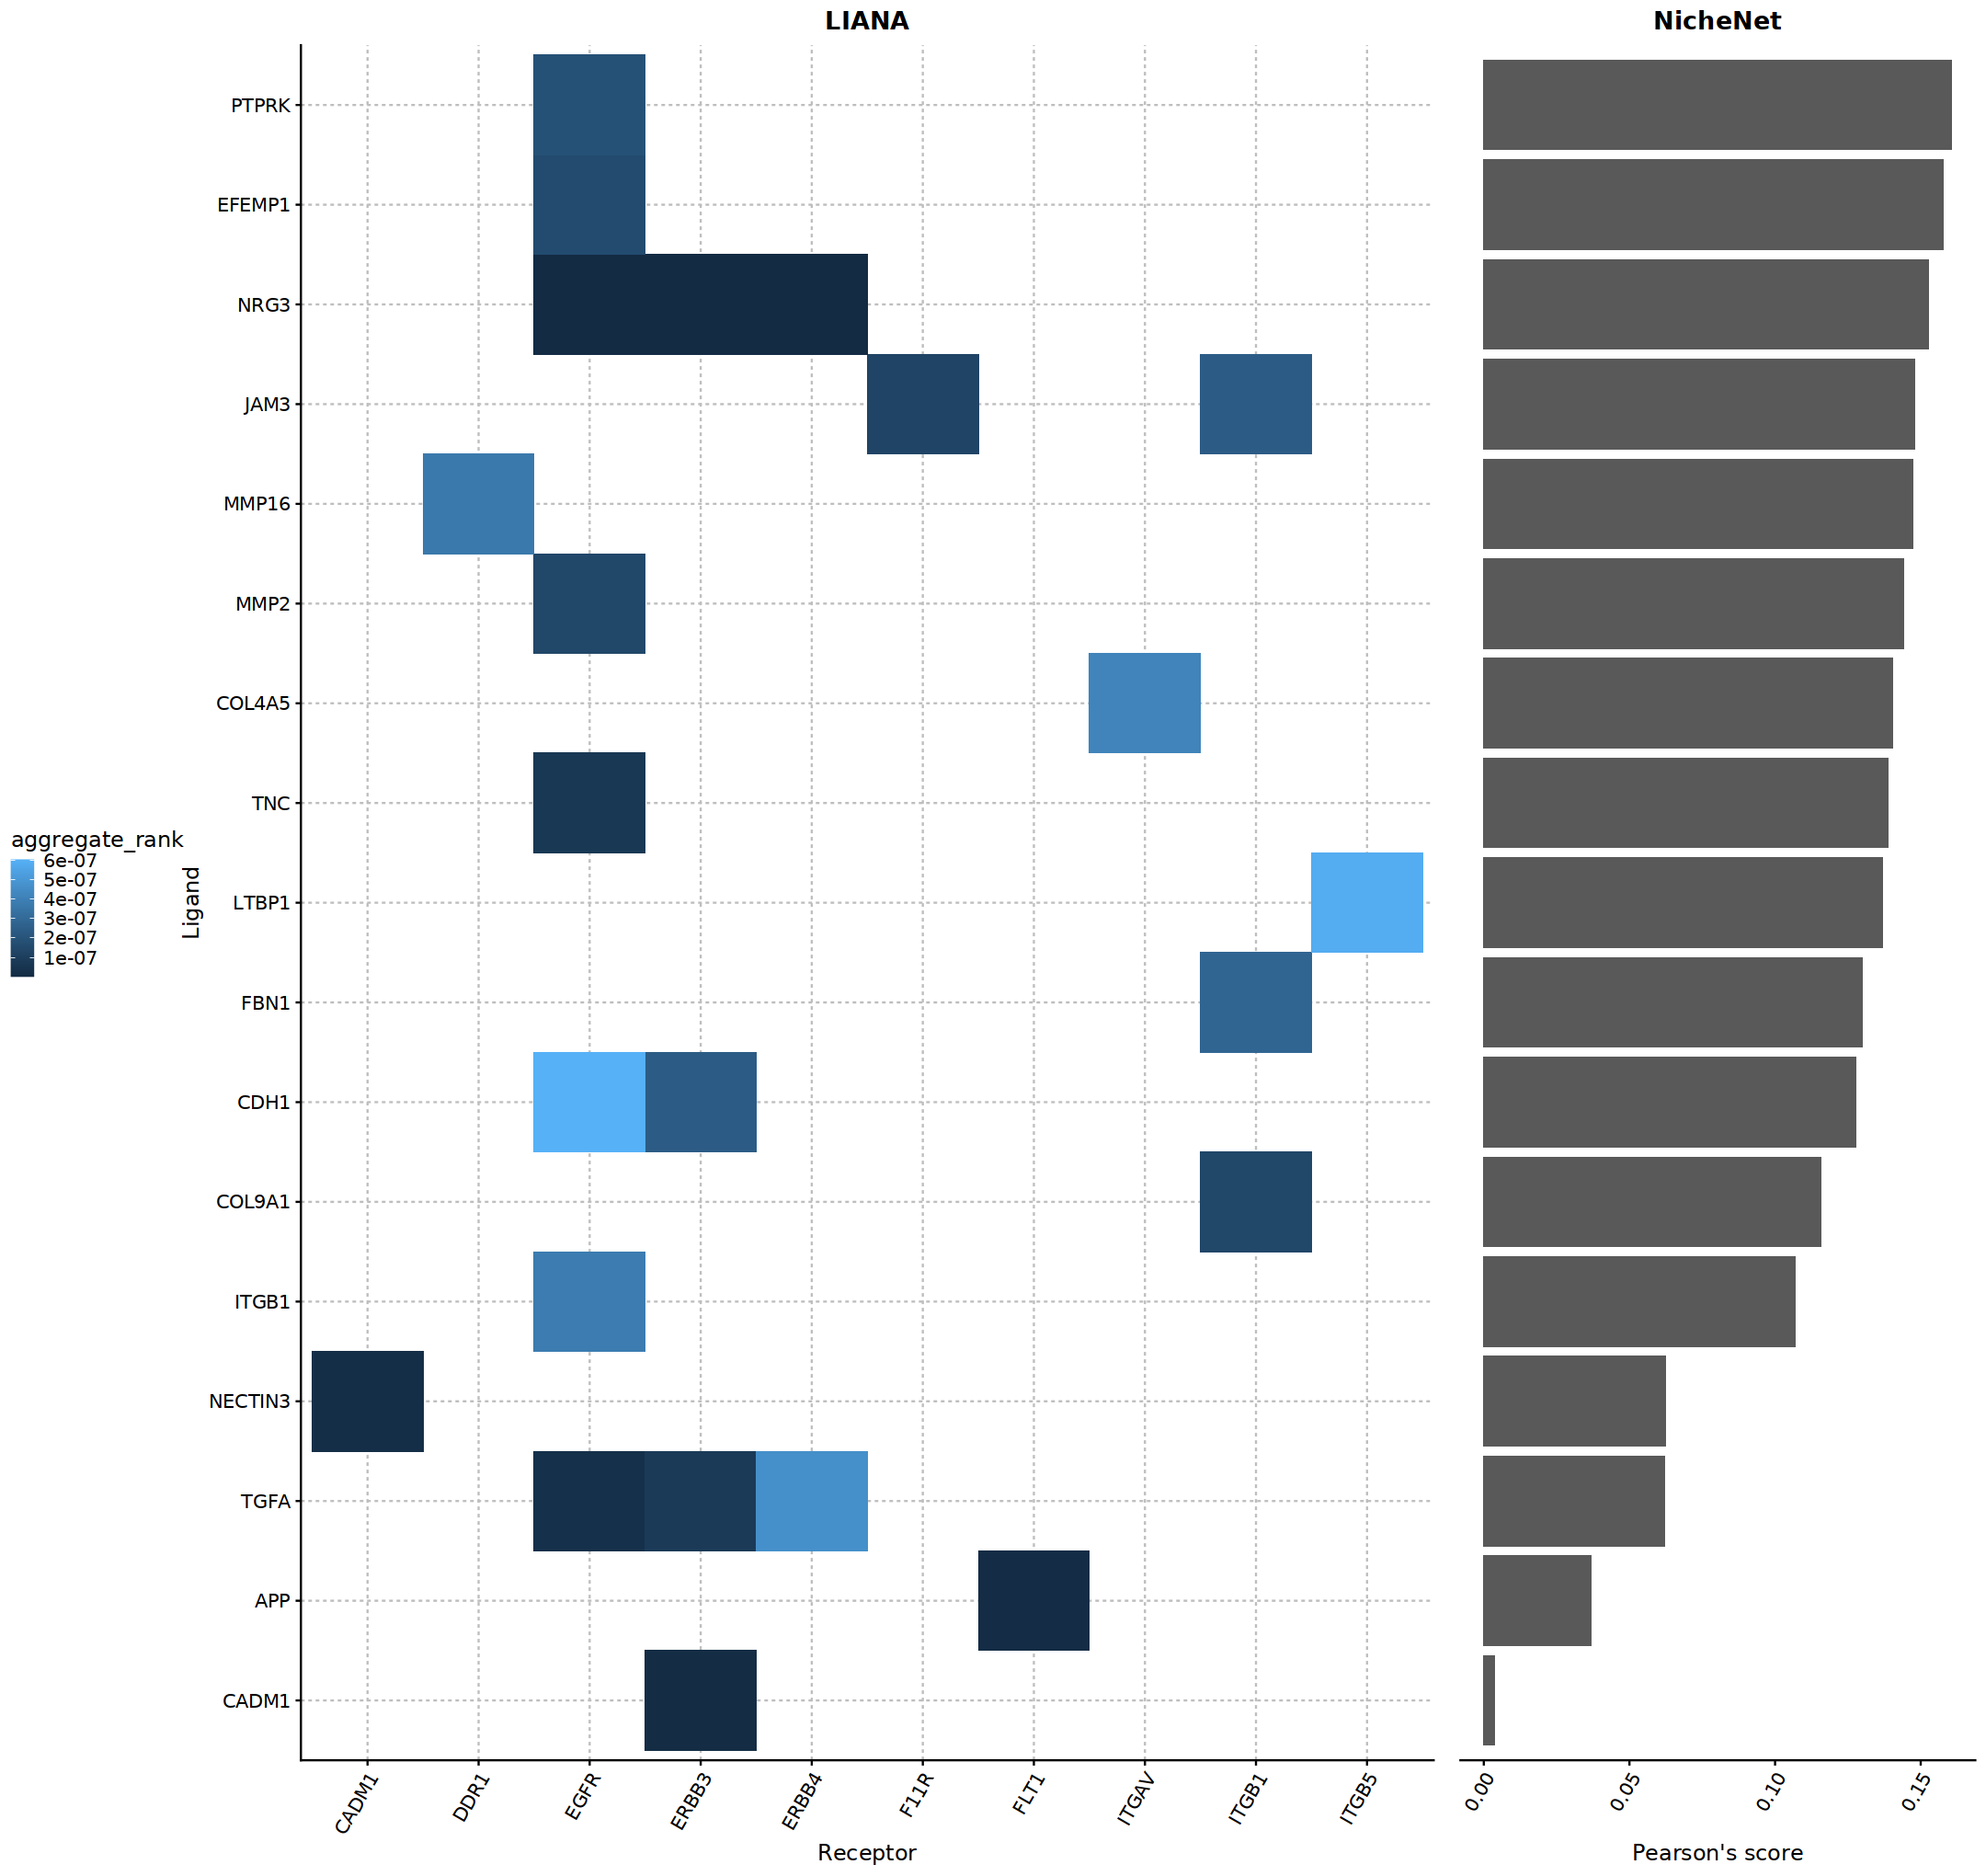

In [67]:
# prepare NicheNet figure
nichenet_scores_plot <- vis_liana_nichenet %>%
  group_by(ligand) %>%
  summarize(pearson = mean(pearson)) %>%
  ggplot(aes(y = ligand, x = pearson)) +
  geom_bar(stat = "identity") +
  ggtitle("NicheNet") +
  xlab("Pearson's score") +
  theme_cowplot() +
  theme(axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank(),
        axis.line.y = element_line(color = "white"),
        plot.title = element_text(hjust = 0.5),
        axis.text.x = element_text(angle = 60, hjust = 1, vjust = 1))

# prepare LIANA figure
liana_receptor_heatmap <- vis_liana_nichenet %>%
  ggplot(aes(y = ligand, x = receptor, fill = aggregate_rank)) +
  geom_tile() +
  theme_cowplot() +
  ggtitle("LIANA") +
  ylab("Ligand") + xlab("Receptor") +
  theme(axis.text.x = element_text(angle = 60, hjust = 1, vjust = 1),
        plot.title = element_text(hjust = 0.5),
        panel.grid.major = element_line(colour = "gray", linetype = 2),
        legend.position = "left")

# combine plots
plot_grid(liana_receptor_heatmap, nichenet_scores_plot,
          align = "h", nrow = 1, rel_widths = c(0.8,0.3))

In [ ]:
expression <- hnscc_expression$expression
sample_info <- hnscc_expression$sample_info
colnames(sample_info) <- make.names(colnames(sample_info))

# filter samples based on vignette's information and add cell type
tumors_remove <-  c("HN10", "HN", "HN12", "HN13", "HN24", "HN7", "HN8", "HN23")
sample_info <- sample_info %>%
  subset( !(tumor %in% tumors_remove) & Lymph.node == 0) %>%
  # fix some cell type identity names
  mutate(cell_type = ifelse(classified..as.cancer.cell == 1, "Tumor", non.cancer.cell.type)) %>%
  subset(cell_type %in% c("Tumor", "CAF"))

# cell ID as rownames
rownames(sample_info) <- sample_info$cell

# subset expression to selected cells
expression <- expression[sample_info$cell, ]

# gene set of interest
geneset_oi <- read_tsv(url("https://zenodo.org/record/3260758/files/pemt_signature.txt"), col_types = cols(), col_names = "gene") %>%
  pull(gene) %>%
  .[. %in% rownames(ligand_target_matrix)]